---
title: Architecture & Formatting Utilities
---

In [1]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 1. Use retina for crisp, PDF-like text
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# 2. Set a high baseline DPI
plt.rcParams["figure.dpi"] = 150

## The Magic String Problem

In Magnetic Resonance, data formats are notoriously fragmented. Vendors use entirely different coordinate systems, units, and metadata keys. If a processing package hardcodes "magic strings" like `"Time"` or `"MHz"` directly into its functions, it inevitably breaks when a user imports data with a `"t"` axis or a `"tx_freq"` attribute.

It also forces users to continually supply repetitive arguments for every step of their pipeline:

```python
# The old, exhaustive way
da_phased = phase(da, time_dim="Time", freq_dim="Frequency")
da_fit = fit(da_phased, time_dim="Time", mhz_key="MHz")
```

## The `DEFAULTS` Solution

To solve this, `xmris` utilizes a **Global Configuration Architecture**. We encapsulate standard `xarray` anatomy (`Dimensions`, `Coordinates`, and `Attributes`) into a single, importable `DEFAULTS` object.

```mermaid
graph TD
    A[xmris.config.DEFAULTS] -->|Defines Dimensions| B(Data Loaders)
    A -->|Defines Attributes| C(Processing Functions)
    A -->|Defines Units| D(Plotting / UI)

    style A fill:#f9f,stroke:#333,stroke-width:2px
```

:::{note}
Users can safely modify `DEFAULTS` at the top of their notebook. Every underlying `xmris` function will instantly adapt to the new naming convention, ensuring maximum compatibility with custom datasets without cluttering function signatures!
:::

Let's see this in action by tackling a common formatting problem: Splitting Complex Arrays.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Ensure the accessor is registered
import xmris

# Import the global configuration
from xmris.config import DEFAULTS

### 1. Inspecting the Defaults
The `DEFAULTS` object provides autocomplete-friendly access to our standard vocabulary. Notice how it strictly adheres to `xarray` terminology.

In [ ]:
print(f"Standard Time Dimension: '{DEFAULTS.time.dim}' [{DEFAULTS.time.units}]")
print(f"Standard Complex Dimension: '{DEFAULTS.component.dim}'")
print(f"Standard Complex Coordinates: {DEFAULTS.component.coords}")
print(f"Standard Field Strength Key: '{DEFAULTS.b0.key}' [{DEFAULTS.b0.units}]")

Standard Time Dimension: 'time' [s]
Standard Complex Dimension: 'component'
Standard Complex Coordinates: ('real', 'imag')
Standard Field Strength Key: 'B0' [T]


### 2. Complex to Real Splitting

Machine Learning pipelines (like PyTorch and TensorFlow) often require complex MR data to be split into separate Real and Imaginary channels because they do not natively support complex numbers across all layers.

By calling `.xmr.to_real_imag()`, the function dynamically queries `DEFAULTS.component` to determine what to name the new dimension and its coordinates. You do not need to provide any arguments.

In [ ]:
# Generate a synthetic complex FID
t = np.linspace(0, 1, 512)
complex_fid = np.exp(-t * 3.0) * np.exp(1j * 2 * np.pi * 15.0 * t)

da_complex = xr.DataArray(
    complex_fid,
    dims=[DEFAULTS.time.dim],  # Use config during array creation
    coords={DEFAULTS.time.dim: t},
    attrs={DEFAULTS.b0.key: 3.0},
    name="Signal",
)

# Split using the default configuration
da_split = da_complex.xmr.to_real_imag()

print("Original Shape:", da_complex.shape)
print("Split Shape:", da_split.shape)
da_split

Original Shape: (512,)
Split Shape: (512, 2)


<xarray.DataArray 'Signal' (time: 512, component: 2)> Size: 8kB
array([[ 1.00000000e+00,  0.00000000e+00],
       [ 9.77285126e-01,  1.82320498e-01],
       [ 9.21845454e-01,  3.56358221e-01],
       ...,
       [ 4.69865295e-02, -1.81636043e-02],
       [ 4.92308338e-02, -9.18441290e-03],
       [ 4.97870684e-02, -5.36673119e-16]])
Coordinates:
  * time       (time) float64 4kB 0.0 0.001957 0.003914 ... 0.9961 0.998 1.0
  * component  (component) <U4 32B 'real' 'imag'
Attributes:
    B0:       3.0

The array cleanly expanded from `(512,)` to `(512, 2)`. Because it is a standard `xarray.DataArray`, we can use the `DEFAULTS` object to quickly plot the two components side-by-side.

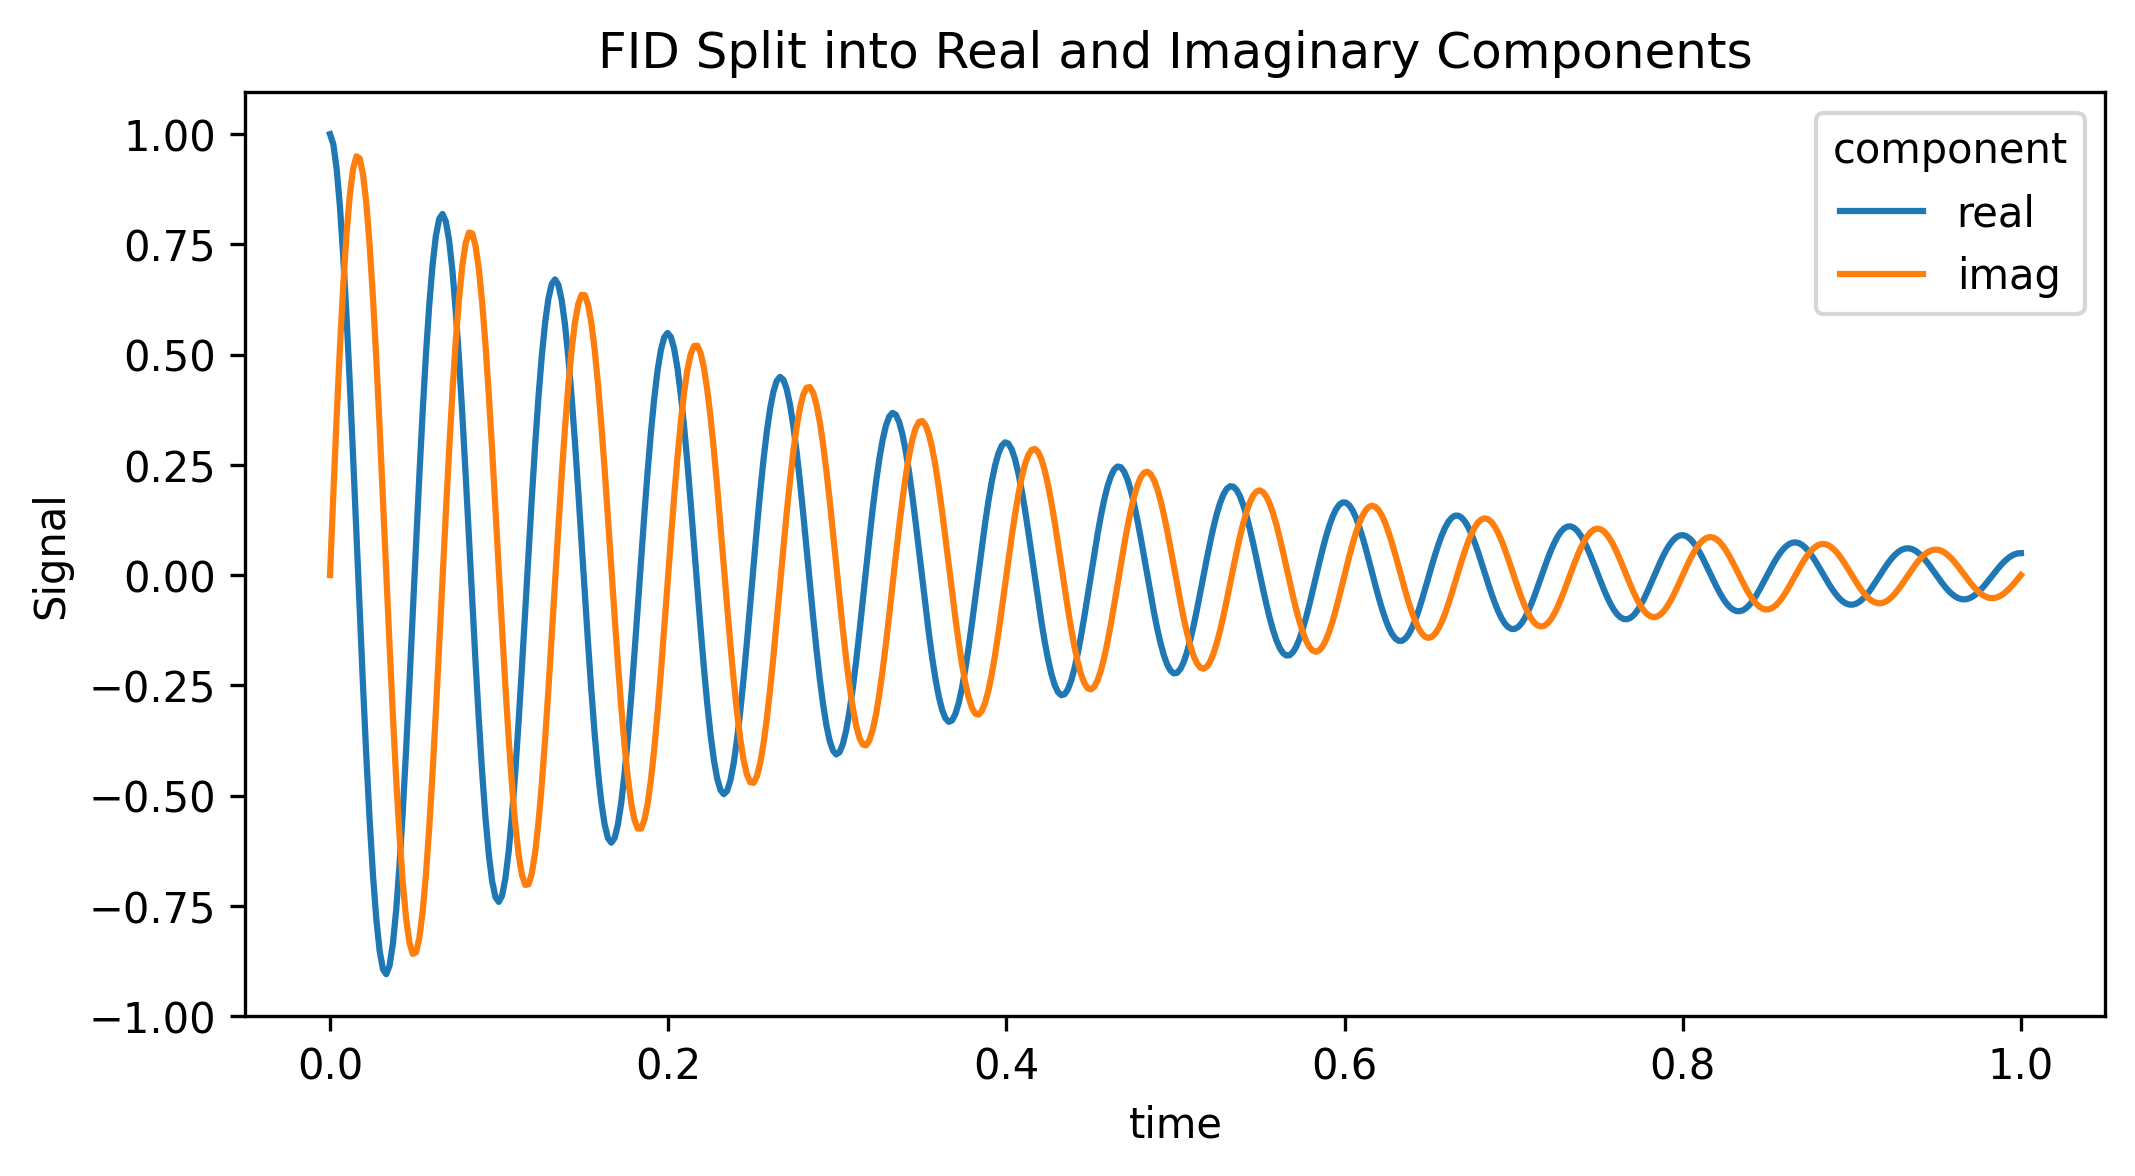

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
# We use the config directly in the plotting call to avoid typos
da_split.plot.line(ax=ax, x=DEFAULTS.time.dim, hue=DEFAULTS.component.dim)
ax.set_title("FID Split into Real and Imaginary Components")
plt.show()

### 3. Overriding the Defaults (User Flexibility)

If a user is dealing with a strict PyTorch pipeline that expects the dimension to be explicitly named `"channel"` instead of `"component"`, they can override the config globally, or pass it directly to the function.

In [ ]:
# Method A: Override for a single call
da_torch = da_complex.xmr.to_real_imag(dim="channel", coords=("ch0", "ch1"))
print("Explicit Override Dimension:", da_torch.dims)

# Method B: Override globally for the whole notebook
DEFAULTS.component.dim = "feature_map"
da_global = da_complex.xmr.to_real_imag()
print("Global Override Dimension:", da_global.dims)

# (Reset for subsequent tests)
DEFAULTS.component.dim = "component"

Explicit Override Dimension: ('time', 'channel')
Global Override Dimension: ('time', 'feature_map')


### 4. Reconstructing the Complex Array

We can seamlessly collapse the dimension back down to a standard complex array for standard signal processing (like an FFT or phase correction) using `.xmr.to_complex()`.

In [ ]:
da_recon = da_split.xmr.to_complex()

is_identical = np.allclose(da_complex.values, da_recon.values)
print(f"Shape Restored: {da_recon.shape}")
print(f"Data Type Restored: {da_recon.dtype}")
print(f"Exact Mathematical Recovery: {is_identical}")

Shape Restored: (512,)
Data Type Restored: complex128
Exact Mathematical Recovery: True


In [ ]:
# STRICT TESTS FOR CI
assert da_split.ndim == da_complex.ndim + 1, "Dimension was not added."
assert da_split.sizes[DEFAULTS.component.dim] == 2, (
    "Component dimension should have size 2."
)
assert not np.iscomplexobj(da_split.values), "Split array should be strictly real."
assert list(da_split.coords[DEFAULTS.component.dim].values) == list(
    DEFAULTS.component.coords
)

assert da_recon.ndim == da_complex.ndim, "Reconstruction failed to drop dimension."
assert np.iscomplexobj(da_recon.values), "Reconstructed array should be complex."
assert DEFAULTS.component.dim not in da_recon.dims, (
    "Component dimension was not fully dropped."
)
np.testing.assert_array_equal(da_recon.values, da_complex.values)
assert da_recon.attrs[DEFAULTS.b0.key] == 3.0, "Reconstruction lost attributes."